# Lab 2: AutoML with Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In this example we use the associated credit card dataset to showcase how you can use AutoML for a simple classification problem. The goal is to predict if a credit card transaction is considered a fraudulent charge.

This notebook is using remote compute to train the model.

If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise, go through the [configuration](../../../configuration.ipynb) notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using remote compute.
4. Explore the results.
5. Test the fitted model.

> Azure AutoML documentation :
https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print('Date:', now)

Date: 2021-03-09 14:38:16.662024


In [3]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [4]:
import azureml.core
print("You are using Azure ML", azureml.core.VERSION)

You are using Azure ML 1.24.0


In [5]:
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl]

In [6]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'Lab2-AutoMLClassification'

experiment=Experiment(ws, experiment_name)

## Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [7]:
import random
randomval=round(random.random()*1000000)
ccname="automlclus"+str(randomval)
ccname

'automlclus676914'

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#Use a unique name
cpu_cluster_name = ccname


try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_F4s_v2',
                                                           vm_priority='dedicated',
                                                           min_nodes=0, # use min_nodes=0 for automatic scaling down to 0 nodess
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=18000) #you can reduce the timeout to avoid extra cost
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Creating....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [9]:
compute_target.provisioning_state

'Succeeded'

In [10]:
compute_target.serialize

<bound method AmlCompute.serialize of AmlCompute(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=automlclus676914, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/AMLworkshop-rg/providers/Microsoft.MachineLearningServices/workspaces/AMLworkshop/computes/automlclus676914, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags=None)>

# Data

### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

Every workspace comes with a default datastore (and you can register more) which is backed by the Azure blob storage account associated with the workspace. We can use it to transfer data from local to the cloud, and create dataset from it. 

In [11]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./data/german_credit_data.csv'],
                       target_path = 'train-dataset/tabular/',
                       overwrite = True,
                       show_progress = True)

Uploading an estimated of 1 files
Uploading ./data/german_credit_data.csv
Uploaded ./data/german_credit_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_ab347bd7fe0848149fa96ea490437469

In [12]:
from azureml.core import Dataset
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'train-dataset/tabular/german_credit_data.csv')])

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own        moderate           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little         moderate           2096   

   Duration    Purpose  Risk  
0         6   radio/TV  good  
1        48   radio/TV   bad  
2        12  education  good

In [13]:
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223) #Partitionning the dataset

label_column_name = 'Risk' # Variable to predict

In [14]:
df=dataset.to_pandas_dataframe()

In [15]:
df.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own        moderate           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little         moderate           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad

In [16]:
try:
    import pandas_profiling
    print("You are using Pandas Profiling:", pandas_profiling.__version__)
except ImportError:
    %pip install pandas_profiling
    
import numpy as np
df.profile_report()

You are using Pandas Profiling: 2.11.0


Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
try:
    import hiplot
    print("You are using HiPlot:", hiplot.__version__)
except ImportError:
    !pip install hiplot

You are using HiPlot: 0.1.23


In [18]:
hiplot.Experiment.from_dataframe(df).display()

<IPython.core.display.Javascript object>

In [19]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [20]:
df.shape

(1000, 10)

In [21]:
df.Risk.value_counts()

good    700
bad     300
Name: Risk, dtype: int64

In [22]:
df.Risk.value_counts(normalize="true")

good    0.7
bad     0.3
Name: Risk, dtype: float64

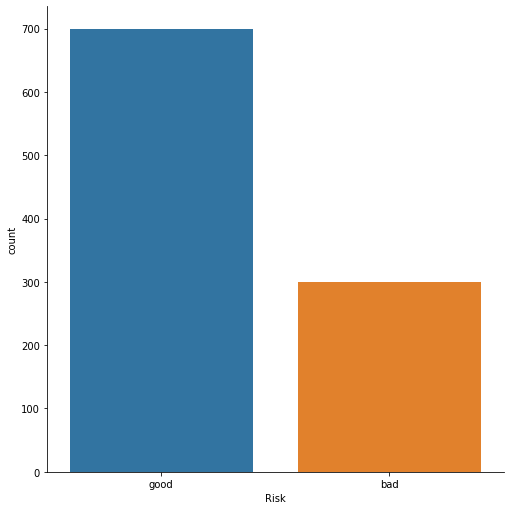

In [23]:
sns.catplot(x="Risk", kind="count", data=df, height=7)

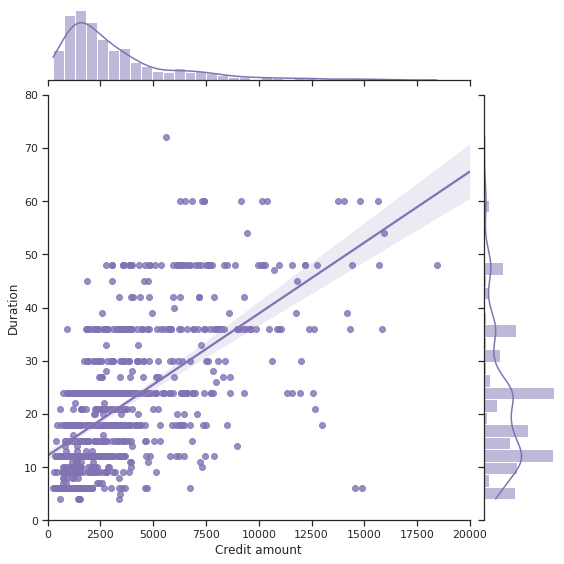

In [24]:
sns.set_theme(style="ticks")
g = sns.jointplot(x="Credit amount", y="Duration", data=df,
                  kind="reg", truncate=False,
                  xlim=(0, 20000), ylim=(0, 80), 
                  color="m", height=8)

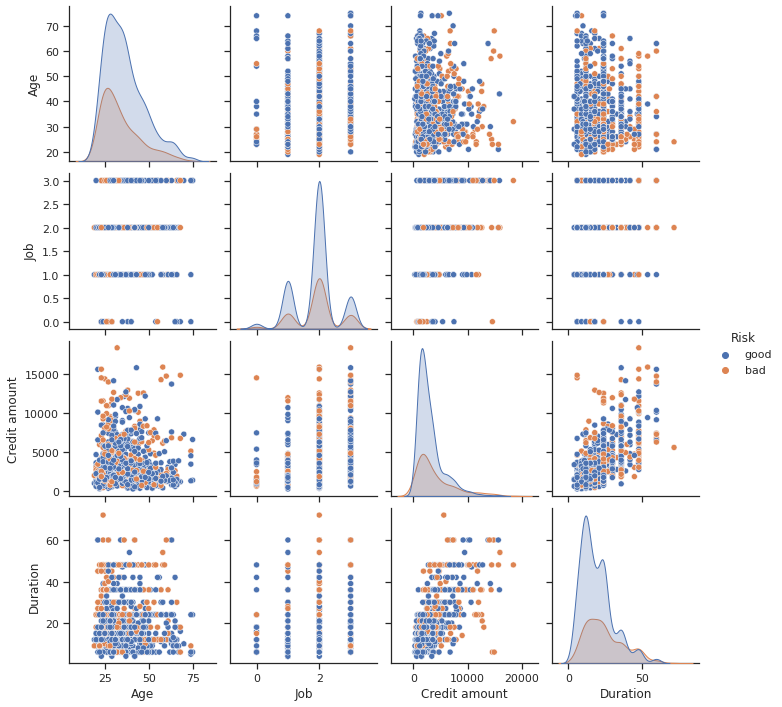

In [25]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Risk")

## Let's save the dataset as an Azure ML dataset

In [26]:
tagsdataset= {"Type": "Test", 
              "Team": "DataScience",
              "Topic": "Fraud",
              "Country": "France",
              "Demo": "Yes",
              "Source" : "https://raw.githubusercontent.com/retkowsky/Samples/master/GermanCreditRisk.csv", 
              }

In [27]:
dataset = dataset.register(workspace=ws,
                           name='CreditRiskDataset',
                           description='Credit Risk Dataset for AutoML',
                           create_new_version=True,
                           tags=tagsdataset)

In [28]:
dataset.name

'CreditRiskDataset'

In [29]:
dataset.tags

{'Type': 'Test',
 'Team': 'DataScience',
 'Topic': 'Fraud',
 'Country': 'France',
 'Demo': 'Yes',
 'Source': 'https://raw.githubusercontent.com/retkowsky/Samples/master/GermanCreditRisk.csv'}

In [30]:
dataset.version

10

## AutoML

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.


**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

Documentation AutoMLConfig : https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py

In [31]:
automl_settings = {
    "n_cross_validations": 3,          # Cross validation
    "primary_metric": 'accuracy',      # Metric
    "iterations": 10,                  # Number of max iterations
    "max_concurrent_iterations": 4,    # Max concurrent iterations
    "experiment_timeout_minutes": 15,  # Timeout in minutes full process
    "iteration_timeout_minutes": 5,    # Timeout per iteration
    "enable_early_stopping": True,     # Early Stopping
    "verbosity": logging.INFO,         # Verbosity
    "featurization": 'auto',           # Data Engineering preprocess
    "enable_stack_ensemble": False,    # No Stack ensemble modelling
    "enable_voting_ensemble" : False,  # No Vote ensemble modelling
    }

automl_config = AutoMLConfig(task = 'classification',               # Classification, Regression or Forecasting AutoML task
                             debug_log = 'automl.log',              # Log file
                             blocked_models=['XGBoostClassifier'],  # Models to exclude if needed.
                             compute_target = compute_target,       # Compute Target to use
                             training_data = training_data,         # Training dataset to use
                             label_column_name = label_column_name, # Target variable to explain
                             **automl_settings                      # Additional settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [32]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote.
No run_configuration provided, running on automlclus676914 with default configuration
Running on remote compute: automlclus676914
Parent Run ID: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing

In [33]:
remote_run.get_status

<bound method Run.get_status of Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc,
Type: automl,
Status: Completed)>

In [34]:
#remote_run.wait_for_completion(show_output=False)

In [35]:
remote_run

Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc,
Type: automl,
Status: Completed)

In [36]:
# We can have the list of all the runs from the current experiment
list_runs = experiment.get_runs()

for run in list_runs:
    print('Run ID:', run.id)

Run ID: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc
Run ID: AutoML_d5af3392-a30c-4475-8a52-047f875f48d8
Run ID: AutoML_97c69068-f412-4d56-97c3-6b9730bea392
Run ID: AutoML_d45b21ff-8001-4021-8d27-f5414a982ac9
Run ID: AutoML_e1a39ea4-0f6e-4270-87ae-4923a36f3ecd
Run ID: AutoML_e5dff122-98b8-4d29-8dec-665789030930
Run ID: AutoML_bc8ed8a8-9db7-4f93-b5ed-294e492778f6
Run ID: AutoML_2468c40f-d460-4628-8c7a-5ecfa042dd32
Run ID: AutoML_290f9b7d-39bc-424a-a8bb-3457286f1d68
Run ID: AutoML_de5d95c6-5b17-47ff-935e-522d32f2c122
Run ID: AutoML_9005ef00-aaa7-4c53-bac7-aea06cbb29a0
Run ID: AutoML_36d15515-8768-4740-84c8-f49f4f69bb4b
Run ID: AutoML_a8130770-fc76-49a5-8752-7f332fdb36c3
Run ID: AutoML_49afdb8c-5123-4fe9-909f-a34225dfb6d0
Run ID: AutoML_863ff150-37f6-4b25-85c2-e4d9d06a6f88
Run ID: AutoML_9954b57c-01c4-4a4e-8747-41bb4a299864
Run ID: AutoML_36dfb895-c5eb-48a3-9a92-66a33d212243
Run ID: AutoML_d8c63248-332f-4486-baaf-75b06ce745ab
Run ID: AutoML_ac971968-b60c-4e59-9165-9d6e9469bddf
Run ID: Auto

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [37]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Analyze results

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [38]:
best_run, fitted_model = remote_run.get_output()

## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [39]:
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [40]:
y_pred = fitted_model.predict(X_test_df)
y_pred

array(['bad', 'good', 'good', 'good', 'bad', 'good', 'bad', 'bad', 'good',
       'good', 'good', 'bad', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       

### Confusion Matrix

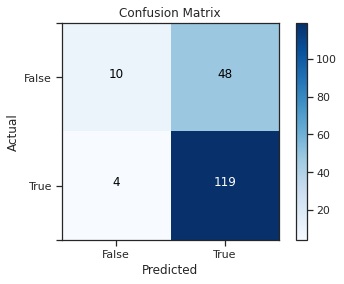

In [41]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## All models

In [42]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

mylist = pd.DataFrame(metricslist).sort_index(1)
mylist

0    1    2    3    4    5    6    7    8  \
recall_score_macro               0.60 0.56 0.52 0.64 0.64 0.64 0.59 0.50 0.50   
weighted_accuracy                0.78 0.84 0.85 0.69 0.67 0.68 0.78 0.85 0.85   
AUC_weighted                     0.67 0.69 0.70 0.68 0.69 0.68 0.66 0.70 0.69   
precision_score_micro            0.71 0.72 0.71 0.67 0.65 0.66 0.70 0.70 0.70   
norm_macro_recall                0.21 0.13 0.04 0.28 0.27 0.28 0.18 0.00 0.00   
average_precision_score_micro    0.75 0.77 0.78 0.71 0.69 0.68 0.73 0.78 0.77   
recall_score_micro               0.71 0.72 0.71 0.67 0.65 0.66 0.70 0.70 0.70   
average_precision_score_weighted 0.72 0.74 0.75 0.72 0.73 0.72 0.70 0.74 0.73   
log_loss                         0.67 0.56 0.57 0.62 0.64 0.80 0.63 0.57 0.58   
recall_score_weighted            0.71 0.72 0.71 0.67 0.65 0.66 0.70 0.70 0.70   
precision_score_weighted         0.69 0.73 0.63 0.70 0.70 0.70 0.67 0.50 0.50   
precision_score_macro            0.64 0.72 0.58 0.63 0.62 0.63 0.62 0.35 0.35   
balanced_accuracy                0.60 0.56 0.52 0.64 0.64 0.64 0.59 0.50 0.50   
AUC_macro                        0.67 0.69 0.70 0.68 0.69 0.68 0.66 0.70 0.69   
f1_score_weighted                0.69 0.66 0.61 0.68 0.66 0.67 0.68 0.58 0.58   
f1_score_micro                   0.71 0.72 0.71 0.67 0.65 0.66 0.70 0.70 0.70   
accuracy                         0.71 0.72 0.71 0.67 0.65 0.66 0.70 0.70 0.70   
AUC_micro                        0.77 0.79 0.79 0.72 0.70 0.71 0.75 0.79 0.79   
average_precision_score_macro    0.66 0.68 0.68 0.66 0.67 0.65 0.63 0.68 0.67   
matthews_correlation             0.24 0.22 0.10 0.27 0.26 0.27 0.21 0.00 0.00   
f1_score_macro                   0.61 0.54 0.46 0.63 0.62 0.62 0.59 0.41 0.41   

                                   9  
recall_score_macro               nan  
weighted_accuracy                nan  
AUC_weighted                     nan  
precision_score_micro            nan  
norm_macro_recall                nan  
average_precision_score_micro    nan  
recall_score_micro               nan  
average_precision_score_weighted nan  
log_loss                         nan  
recall_score_weighted            nan  
precision_score_weighted         nan  
precision_score_macro            nan  
balanced_accuracy                nan  
AUC_macro                        nan  
f1_score_weighted                nan  
f1_score_micro                   nan  
accuracy                         nan  
AUC_micro                        nan  
average_precision_score_macro    nan  
matthews_correlation             nan  
f1_score_macro                   nan

## Best Model

In [43]:
best_run, fitted_model = remote_run.get_output()
print("Best AutoML run =", best_run)

Best AutoML run = Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc_1,
Type: azureml.scriptrun,
Status: Completed)


In [44]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('MaxAbsScaler', MaxAbsScaler(copy=True)),
 ('RandomForestClassifier',
  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='sqrt',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=0.01,
                         min_samples_split=0.10368421052631578,
                         min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                         oob_score=False, random_state=None,

In [45]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                   

In [46]:
fitted_model.get_params

<bound method PipelineWithYTransformations.get_params of PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=None,
                                                                  enable_feature_sweeping=None,
                                                                  feature_sweeping_config=None,
                                                                  feature_sweeping_timeout=None,
                                                                  featurization_config=None,
                                                                  force_text_dnn=None,
                                                                  is_cross_validation=None,
                                                                  is_onnx_compatible=None,
                                                                  logger=None,
     

In [47]:
print("Metrics of the best model:")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Metrics of the best model:

- recall_score_micro = 0.724053724053724
- precision_score_weighted = 0.7256281758619859
- AUC_weighted = 0.6947752647999615
- weighted_accuracy = 0.8390030325209805
- f1_score_macro = 0.5397597358265149
- average_precision_score_weighted = 0.7400965465988252
- AUC_micro = 0.7869911935846002
- average_precision_score_macro = 0.6794681327981453
- average_precision_score_micro = 0.7720787391729073
- recall_score_weighted = 0.724053724053724
- balanced_accuracy = 0.5633824888250623
- AUC_macro = 0.6947752647999615
- accuracy = 0.724053724053724
- f1_score_weighted = 0.6577180927806322
- f1_score_micro = 0.724053724053724
- log_loss = 0.561029867457816
- norm_macro_recall = 0.12676497765012443
- precision_score_macro = 0.7178056547337621
- recall_score_macro = 0.5633824888250623
- matthews_correlation = 0.22183612733478
- precision_score_micro = 0.724053724053724
- accuracy_table = aml://artifactId/ExperimentRun/dcid.AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc_1

## We can choose any iteration

In [48]:
iteration = 2

my_run, my_model = remote_run.get_output(iteration = iteration)
print("Model",iteration," iteration :")
print(my_run)
print()
print(my_model)

Model 2  iteration :
Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc_2,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
      

### We want to keep the best model

In [49]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Metrics:")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: Lab2-AutoMLClassification,
Id: AutoML_cefb15cd-2a63-4bba-a717-bcfb209f23fc_1,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MaxAbsScaler', MaxAbsScaler(copy...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                          

In [50]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
MaxAbsScaler
RandomForestClassifier


In [51]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', 
                        model_name='BestAutoMLModel',
                        tags={'Training Context':'Azure Auto ML', 
                              'Compute Cluster':'Yes', 
                              'Topic':'Fraud Detection'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 
                                    'Average Precision Score': best_run_metrics['average_precision_score_weighted'],
                                    'Accuracy': best_run_metrics['accuracy'],
                                    'Precision': best_run_metrics['precision_score_weighted']}
                       )

Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=BestAutoMLModel, id=BestAutoMLModel:19, version=19, tags={'Training Context': 'Azure Auto ML', 'Compute Cluster': 'Yes', 'Topic': 'Fraud Detection'}, properties={'AUC': '0.6947752647999615', 'Average Precision Score': '0.7400965465988252', 'Accuracy': '0.724053724053724', 'Precision': '0.7256281758619859'})

In [52]:
best_run.properties

{'runTemplate': 'automl_child',
 'pipeline_id': 'cf1dc9b7ea4a50d759bce352343ec6737501695a',
 'pipeline_spec': '{"objects": [{"class_name": "MaxAbsScaler", "module": "sklearn.preprocessing", "param_args": [], "param_kwargs": {}, "prepared_kwargs": {}, "spec_class": "preproc"}, {"class_name": "RandomForestClassifier", "module": "sklearn.ensemble", "param_args": [], "param_kwargs": {"bootstrap": false, "class_weight": null, "criterion": "gini", "max_features": "sqrt", "min_samples_leaf": 0.01, "min_samples_split": 0.10368421052631578, "n_estimators": 10, "oob_score": false}, "prepared_kwargs": {}, "spec_class": "sklearn"}], "pipeline_id": "cf1dc9b7ea4a50d759bce352343ec6737501695a", "module": "sklearn.pipeline", "class_name": "Pipeline", "pipeline_name": "{ MaxAbsScaler, RandomForestClassifier }"}',
 'training_percent': '100',
 'predicted_cost': '0.5',
 'iteration': '1',
 '_aml_system_scenario_identification': 'Remote.Child',
 '_azureml.ComputeTargetType': 'amlcompute',
 'ContentSnapshotId

In [53]:
experiment

Experiment(Name: Lab2-AutoMLClassification,
Workspace: AMLworkshop)

> You can open now the **Lab3 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">